In [3]:
import pickle
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import pairwise_distances

import os
os.chdir('../Notebooks')
from clustering_evaluation import ClusterPurity
evaluator=ClusterPurity()

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Load pre-trained KG model:

In [5]:
# transe_fb15k-237.pkl: pre-trained model of fb15k with 1024 dim.
with open("../dataset/distmult_fb15k_256dim.pkl", "rb") as fin:
    model = pickle.load(fin)
    
entity2id = model.graph.entity2id
relation2id = model.graph.relation2id

entity_embeddings = model.solver.entity_embeddings
relation_embeddings = model.solver.relation_embeddings

In [6]:
entity_embeddings.shape

(14951, 256)

In [7]:
#process current id format (e.g./m/09kqc) to be as in the original data (e.g m.09kqc)
entities_ids=[x.replace('/', '.')[1:] for x in entity2id.keys()] 

## Get ground-truth from FB dataset:

In [8]:
fb_entity_types= pd.read_csv('../dataset/fb_types.tsv', delimiter="\t", header=None, index_col=0)
fb_entity_types.columns = ["type"]

In [9]:
fb15k=fb_entity_types[fb_entity_types.index.isin(entities_ids)] #get types for FB15 from the original FB dataset
fb15k_OneClass = fb15k[~fb15k.index.duplicated(keep='first')] #there are entities with multiple types, we choose only the first.
fb15k_OneClass.shape

(14918, 1)

In [10]:
fb15k_OneClass.head()

,type
0,
m.011hq1,/ns/base.jobmastates.topic
m.012_53,/ns/base.saturdaynightlive.snl_host
m.013mj_,/ns/government.governmental_jurisdiction
m.014w_8,/ns/base.type_ontology.abstract
m.016gr2,/ns/award.award_winner


In [11]:
fb15k_OneClass["type"].value_counts()

/ns/common.topic                                     1379
/ns/base.type_ontology.inanimate                      757
/ns/base.type_ontology.abstract                       751
/ns/base.type_ontology.agent                          614
/ns/base.type_ontology.non_agent                      470
                                                     ... 
/ns/base.sportsrecords.sports_tournament                1
/ns/basketball.basketball_player                        1
/ns/user.bruceesrig.default_domain.product_skills       1
/ns/base.poetrybase.topic                               1
/ns/base.anzacs.topic                                   1
Name: type, Length: 1187, dtype: int64

In [12]:
# Filter fb15k_df by top k types
fb15k_df_filter=fb15k_OneClass.loc[fb15k_OneClass.type.isin(['/ns/common.topic','/ns/base.type_ontology.inanimate',
                                                             '/ns/base.type_ontology.abstract','/ns/base.type_ontology.agent ','/ns/base.type_ontology.non_agent'])]

#fb15k_df_filter=fb15k_OneClass

In [13]:
fb15k_df_filter.head()

,type
0,
m.014w_8,/ns/base.type_ontology.abstract
m.022fhd,/ns/common.topic
m.027c924,/ns/common.topic
m.02_tw,/ns/base.type_ontology.inanimate
m.02k6pv,/ns/base.type_ontology.inanimate


In [14]:
ground_truth={} # y_true labels for filter types (top k)
for entity, entity_proc in zip(entity2id.keys(), entities_ids):    
    if entity_proc in fb15k_df_filter.index:
        ground_truth[entity]=fb15k_df_filter.at[entity_proc, 'type']

In [15]:
y_true=[]
entity_embeddings_filter=np.zeros((len(ground_truth), entity_embeddings.shape[1]), dtype=float)
i=0
for k, value in sorted(ground_truth.items(), reverse=False):    
    entity_embeddings_filter[i]=entity_embeddings[entity2id[k]] # mapping entity embedding at k index to entity_embedding_filter i
    i+=1
    y_true.append(value)

In [16]:
le =LabelEncoder()
y_encoded=le.fit_transform(y_true)

# Split data: train-test

In [17]:
X_train, X_test, y_train, y_test = train_test_split( entity_embeddings_filter, y_encoded, test_size=0.33, random_state=42)

## t-SNE Freebase visualization

In [18]:
# plotting the data before clustering:
projection_full = TSNE(random_state=42).fit_transform(entity_embeddings_filter)
projection_train = TSNE(random_state=42).fit_transform(X_train)
projection_test = TSNE(random_state=42).fit_transform(X_test)

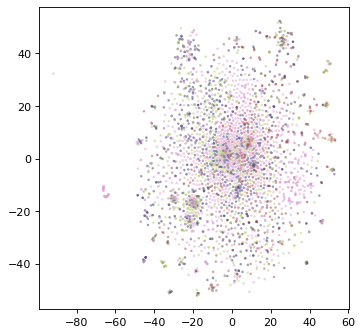

In [19]:
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(*projection_full.T,s=5,  cmap='tab20b', c=y_encoded, linewidth=0, alpha=0.5) 

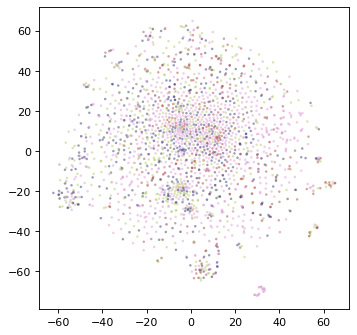

In [20]:
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(*projection_train.T,s=5,  cmap='tab20b', c=y_train, linewidth=0, alpha=0.5) 

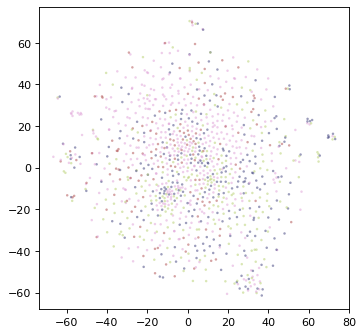

In [21]:
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(*projection_test.T,s=5,  cmap='tab20b', c=y_test, linewidth=0, alpha=0.5) 

## Density-based Embeddings:

## HDBSCAN:

In [22]:
import hdbscan

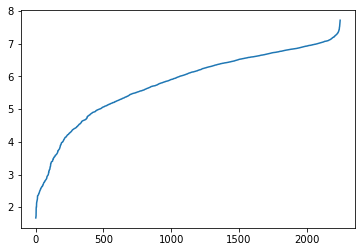

In [23]:
# final optimal value for cluster epsilon
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X_train)
distances, indices = nbrs.kneighbors(X_train)

distances = np.sort(distances, axis=0)
distances = distances[:,-1]
plt.plot(distances)

In [24]:
hdbscan_clusterer=hdbscan.HDBSCAN(algorithm='best', alpha=0.3, metric='precomputed', cluster_selection_method='leaf',
                                      min_samples=5, min_cluster_size=50, core_dist_n_jobs=-1,allow_single_cluster=True,
                                      cluster_selection_epsilon=7.5)

distance_matrix = pairwise_distances(X_train, metric='cosine')
hdbscan_clusterer.fit(distance_matrix, y_train)

ytrain_labels=hdbscan_clusterer.labels_

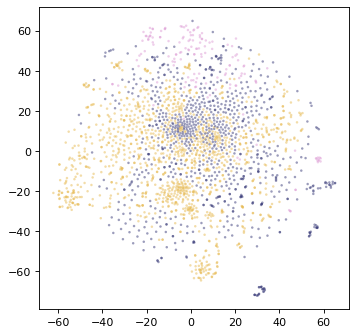

In [25]:
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(*projection_train.T,s=5,  cmap='tab20b', c=ytrain_labels, linewidth=0, alpha=0.5) 

### Evaluation

#### Results of train dataset:

In [26]:
    #----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_train, ytrain_labels)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_train, ytrain_labels, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_train, ytrain_labels, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_train, ytrain_labels, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_train, y_pred=ytrain_labels))

Accuracy: 0.154735
Precision: 0.112932
Recall: 0.154735
F1 score: 0.103174
Purity:  0.40907069808803914


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Results for test dataset:

In [27]:
distance_matrix = pairwise_distances(X_test, metric='cosine')
hdbscan_clusterer.fit(distance_matrix, y_test)
ytest_labels=hdbscan_clusterer.labels_

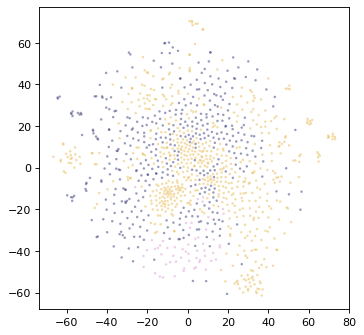

In [28]:
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(*projection_test.T,s=5,  cmap='tab20b', c=ytest_labels, linewidth=0, alpha=0.5) 

In [29]:
    #----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, ytest_labels)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, ytest_labels, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, ytest_labels, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, ytest_labels, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_test, y_pred=ytest_labels))

Accuracy: 0.154332
Precision: 0.096999
Recall: 0.154332
F1 score: 0.099498
Purity:  0.41787003610108303


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Centroid-based Clustering (K-means):

In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5).fit(X_train)
y_kmeans=kmeans.predict(X_test)

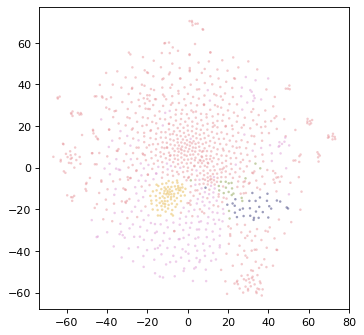

In [31]:
plt.figure(figsize=(5, 5), dpi=80)

plt.scatter(*projection_test.T,s=5,  cmap='tab20b', c=y_kmeans, linewidth=0, alpha=0.5) 

In [32]:
    #----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_kmeans)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_kmeans, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_kmeans, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_kmeans, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_test, y_pred=y_kmeans))

Accuracy: 0.338448
Precision: 0.359351
Recall: 0.338448
F1 score: 0.271164
Purity:  0.4287003610108303


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Agglomerative Clustering:

In [33]:
from sklearn.cluster import AgglomerativeClustering
aggClustering = AgglomerativeClustering(n_clusters=5).fit(X_train)
y_aggClustering=aggClustering.fit_predict(X_test)

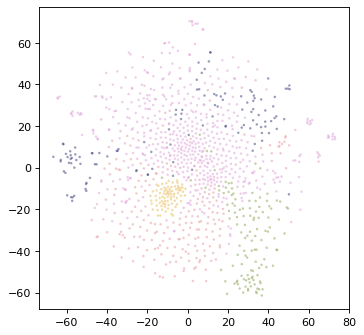

In [34]:
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(*projection_test.T,s=5, cmap='tab20b', c=y_aggClustering, linewidth=0, alpha=0.5) 

In [35]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_aggClustering)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_aggClustering, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_aggClustering, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_aggClustering, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_test, y_pred=y_aggClustering))

Accuracy: 0.129964
Precision: 0.283415
Recall: 0.129964
F1 score: 0.178124
Purity:  0.44223826714801445


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Supervised Baselines:

## Logistic Regression:

In [36]:
from sklearn.linear_model import LogisticRegression

logistic_clf = LogisticRegression(solver='liblinear',random_state=42).fit(X_train, y_train.ravel())
y_lr = logistic_clf.predict(X_test)

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_lr)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_lr, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_lr, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_lr, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_lr))

Accuracy: 0.398917
Precision: 0.372591
Recall: 0.398917
F1 score: 0.380186
Purity Score:  0.41425992779783394


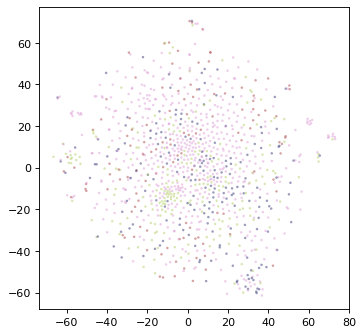

In [37]:
plt.figure(figsize=(5, 5), dpi=80)

plt.scatter(*projection_test.T,s=5,  cmap='tab20b', c=y_lr, linewidth=0, alpha=0.5) 

## KNN:

In [38]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train.ravel())
y_knn = neigh.predict(X_test)

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_knn)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_knn, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_knn, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_knn, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_knn))

Accuracy: 0.330325
Precision: 0.336740
Recall: 0.330325
F1 score: 0.329084
Purity Score:  0.41425992779783394


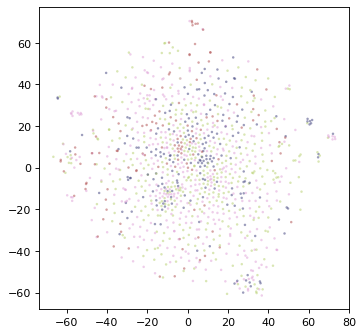

In [39]:
plt.figure(figsize=(5, 5), dpi=80)

plt.scatter(*projection_test.T,s=5,  cmap='tab20b', c=y_knn, linewidth=0, alpha=0.5) 

## RandomForest:

In [40]:
from sklearn.ensemble import RandomForestClassifier

random_clf = RandomForestClassifier(random_state=42).fit(X_train, y_train.ravel())
y_rf= random_clf.predict(X_test)

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_rf)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_rf, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_rf, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_rf, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_rf))

Accuracy: 0.409747
Precision: 0.351454
Recall: 0.409747
F1 score: 0.314187
Purity Score:  0.4187725631768953


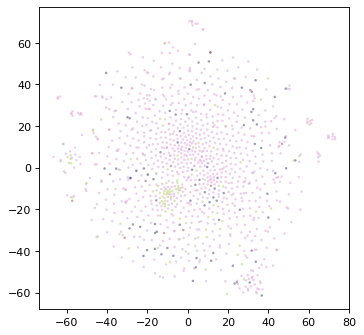

In [41]:
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(*projection_test.T,s=5,  cmap='tab20b', c=y_rf, linewidth=0, alpha=0.5) 